<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax_cosmo/blob/master/notebooks/jax-cosmo-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to jax-cosmo

Authors:
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

`jax-cosmo` brings the power of automatic differentiation and XLA execution
to cosmological computations, all the while preserving the readability and human
friendliness of Python / NumPy.

This is made possible by the [JAX](https://jax.readthedocs.io/en/latest/index.html) framework, which can be summarised as JAX = NumPy + autograd + GPU/TPU. We
encourage the interested reader to follow this [introduction to JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) but it will not be necessary to follow this notebook.


### Learning objectives

In this short introduction we will cover:
  - How to define computations of **2pt functions**
  - How to execute these computations on **GPU** (spoiler alert, you actually don't need to do anything, it happens automatically)
  - How to **take derivatives** of any quantities by automatic differentation
  - And finally, how to piece all of this together for efficient and reliable **Fisher matrices**.





## Installing and importing jax-cosmo

One of the important aspects of `jax-cosmo` is that it is entirely Python-based
so it can trivially be installed without compiling or downloading any third-party tools.

Here is how to install the current release on your system:

In [0]:
# Installing jax-cosmo
!pip install --quiet jax-cosmo

For efficient computation on GPU (if you have one), you might want to make sure that JAX itself is installed with the proper GPU-enabled backend. See [here](https://github.com/google/jax#installation) for more instructions.

Now that `jax-cosmo` is installed, let's import it along with JAX tools:

In [2]:
%pylab inline
import jax
import jax_cosmo as jc
import jax.numpy as np

Populating the interactive namespace from numpy and matplotlib


**Note that we import the JAX version of NumPy here**. That's all that you have to do, any numpy functions you will use afterwards will be JAX-accelerated and differentiable.

And for the purpose of this tutorial we also define a few plotting functions in the cell bellow, please run it.

In [0]:
#@title Defining some plotting functions [run me]

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(hessian, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = - hessian
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

## Defining a Cosmology and computing background quantities

We'll beginning with the basics, let's define a cosmology:


In [0]:
# Create a cosmology with default parameters
cosmo = jc.Planck15()

In [0]:
# Alternatively we can override some of the defaults
cosmo_modified = jc.Planck15(h=0.7)

In [6]:
# Parameters can be easily accessed from the cosmology object
cosmo.h

0.6774

All background quantities can be computed from the `jax_cosmo.background` module, they typically take the cosmology as first argument, and a scale factor
argument if they are not constant.

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


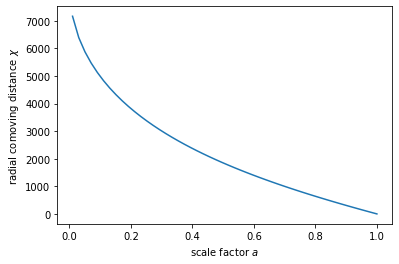

In [9]:
# Let's define a range of scale factors
a = np.linspace(0.01, 1.)

# And compute the comoving distance for these scale factors 
chi = jc.background.radial_comoving_distance(cosmo, a)

# We can now plot the results:
plot(a, chi)
xlabel(r'scale factor $a$')
ylabel(r'radial comoving distance $\chi$');

In [0]:
# Not sure what are the units of the comoving distance? just ask:
jc.background.radial_comoving_distance?

## Defining redshift distributions

On our path to computing Fisher matrices, we need to be able to express redshift distrbutions. In `jax-cosmo` n(z) are parametrized functions which can
be found in the `jax_cosmo.redshift` module. 

For the purpose of this tutorial, let's see how to define a Smail type distribution:
$$ n(z) = z^a \exp(- (z/z_0)^b) $$
which depends on 3 parameters:

In [0]:
# You can inspect the documentation to see the 
# meaning of these positional arguments
nz1 = jc.redshift.smail_nz(1., 2.,  1.)
nz2 = jc.redshift.smail_nz(1., 2.,  0.5)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


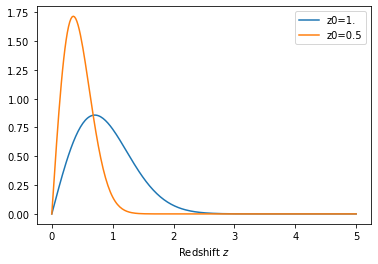

In [11]:
# And let's plot it
z = np.linspace(0,5,256)

# Redshift distributions are callable, and they return the normalized distribution
plot(z, nz1(z), label='z0=1.')
plot(z, nz2(z), label='z0=0.5')
legend();
xlabel('Redshift $z$');

In [12]:
# We can check that the nz is properly normalized
jc.scipy.integrate.romb(nz1, 0., 5.)

DeviceArray(1.0000004, dtype=float32)

Nice :-D 

### Defining probes and computing angular $C_\ell$

Let's now move on to define lensing and clustering probes using these two n(z).
In `jax-cosmo` a probe/tracer of a given type, i.e. lensing, contains a series of parameters, like redshift distributions, or galaxy bias. Probes are hosted in
the `jax_cosmo.probes` module.

$C_\ell$ computations will then take as argument a list of probes and will compute all auto- and cross- correlations between all redshift bins of all probes. 

In [0]:
# First we define a list of redshift bins
nzs = [nz1, nz2]

In [0]:
# And now we define 2 probes 
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26), 
           jc.probes.NumberCounts(nzs, jc.bias.constant_linear_bias(1.)) ]

Given these probes, we can now compute tomographic angular power spectra for these probes using the `angular_cl` tools hosted in the `jax_cosmo.angular_cl` module. For now, all computations are done under the Limber approximation.

In [0]:
# Let's define a range of \ell
ell = np.logspace(1,3)

# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo, ell, probes)

In [16]:
# Let's check the shape of these Cls
cls.shape

(10, 50)

We see that we have obtained 10 spectra, each of them of size 50, which is the length of the $\ell$ vector. They are ordered first by probe, then by redshift bin. So the first cl is the lensing auto-spectrum of the first bin

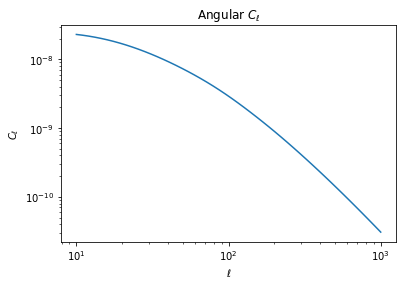

In [17]:
# This is for instance the first bin auto-spectrum 
loglog(ell, cls[0])
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');

In addition to the data vector, we can also compute the covariance matrix using the tools from that module. Here is an example:

In [0]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes);

The data vector from this function is in a flattened shape so that it can be multiplied by the covariance matrix easily.

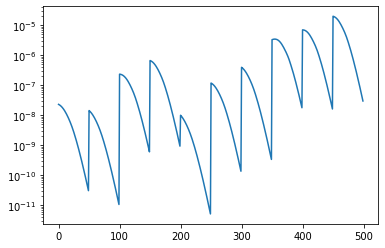

In [19]:
semilogy(mu);

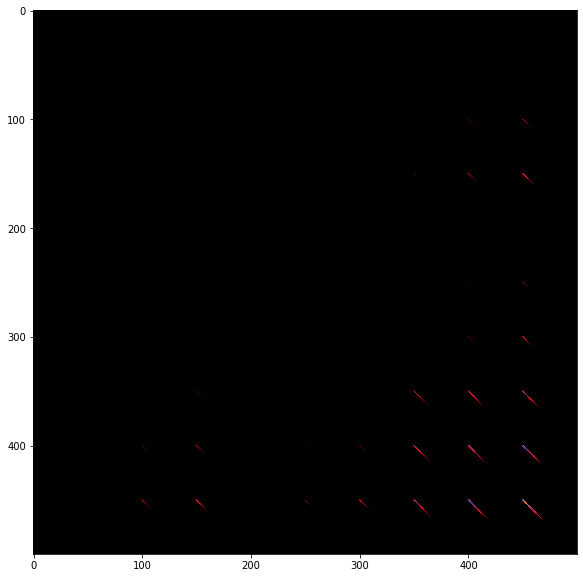

In [20]:
figure(figsize=(10,10))
imshow(np.log10(cov+1e-11),cmap='gist_stern');

### Where the wild things are: Automatic Differentiation

Now that we know how to compute various quantities, we can move on to the amazing part, computing gradients automatically by autodiff. As an example, we
will demonstrate how to analytically **compute Fisher matrices, without finite differences.** But gradients are usefull for a wide range of other applications.


We begin by defining a Gaussian likelihood function for the data vector we have 
obtained at the previous step. And we make this likelihood function depend on an array of parameters, `Omega_c`, `sigma_8`.
 



In [0]:
# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.
data = mu;
params = np.array([cosmo.Omega_c, cosmo.sigma8])

# Note the `jit` decorator for just in time compilation, this makes your code
# run fast on GPU :-)
@jax.jit
def likelihood(p):
  # Create a new cosmology at these parameters
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])

  # Compute mean and covariance of angular Cls
  m, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes)

  # Return likelihood value assuming constant covariance, so we stop the gradient
  # at the level of the precision matrix, and we will not include the logdet term
  # in the likelihood
  P = jax.lax.stop_gradient(np.linalg.inv(C))
  r = data - m
  return -0.5 * (r.T @ P @ r)

In [23]:
# Computing the likelihood at our fiducial params, we should get 0 since we don't
# have the normalization term
print(likelihood(params))
%timeit likelihood(params).block_until_ready()

-3.7244496e-09
10 loops, best of 3: 40.6 ms per loop


In [0]:
# But wait, there is more! We can compute the derivatives of the likelihood
grad_loglik = jax.jit(jax.grad(likelihood))

In [0]:
print(grad_loglik(params))
%timeit grad_loglik(params).block_until_ready()

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in

[ 91199.54 120366.52]
1 loop, best of 3: 203 ms per loop


In [0]:
# And now, the killer example! Hessian of the likelihood

In [0]:
hessian_loglik = jax.jit(jax.hessian(likelihood))

In [0]:
H = hessian_loglik(params)
%timeit hessian_loglik(params).block_until_ready()

1 loop, best of 3: 299 ms per loop


Text(14.375, 0.5, 'sigma8')

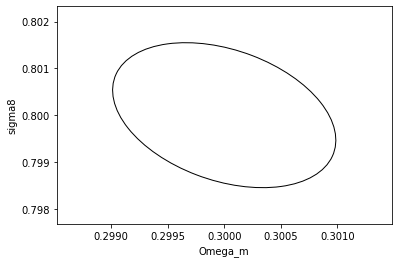

In [0]:
# Let's compute the Fisher matrix, i.e. the same thing but at the true cosmmology
H = hessian_loglik(np.array([cosmo.Omega_c, cosmo.sigma8]))

plot_contours(H, params, fill=False);
xlabel('Omega_m')
ylabel('sigma8')